In [1]:
import pandas as pd
import os
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)

Setup and Load

In [3]:
base_dir = r"D:/Path/to/the/directory/where/the/extracted_mimic_iii_data/is/stored"
in_csv = os.path.join(base_dir, "MERGED", "master_24h.csv")
df = pd.read_csv(in_csv)

raw_cols = df.columns.tolist()

# Basic types
df['HOSPITAL_EXPIRE_FLAG'] = df['HOSPITAL_EXPIRE_FLAG'].astype(int)
df['GENDER'] = df['GENDER'].astype('category')
df['ADMISSION_TYPE'] = df['ADMISSION_TYPE'].astype('category')

In [4]:
# Added to avoid errors later (should end up empty)
os.makedirs(os.path.join(base_dir, "SNAP"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "FIGS"), exist_ok=True)

Feature Lists

In [5]:
label_col = 'HOSPITAL_EXPIRE_FLAG'
cat_cols = ['GENDER','ADMISSION_TYPE']  # categorical
num_cols = [c for c in df.columns if c.endswith(('_mean','_min','_max'))] + ['AGE', 'LOS']

# Columns to drop to avoid information lekage
drop_cols = ['DIAGNOSIS','INTIME','OUTTIME','SUBJECT_ID','HADM_ID','ICUSTAY_ID']

Exploratory Data Analysis (EDA) Check

Top missing numeric: LACTATE_mean    0.554622
LACTATE_min     0.554622
LACTATE_max     0.554622
DBP_max         0.371075
DBP_min         0.371075
DBP_mean        0.371075
SBP_max         0.371059
SBP_min         0.371059
SBP_mean        0.371059
MAP_max         0.370961
dtype: float64


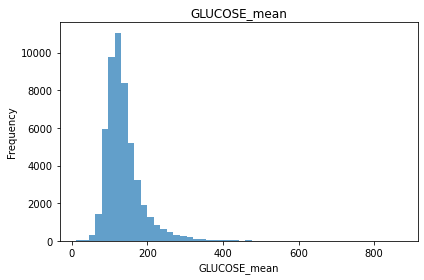

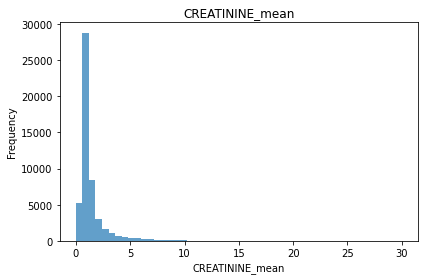

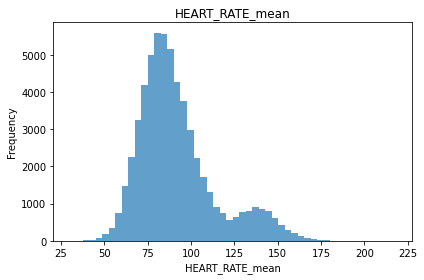

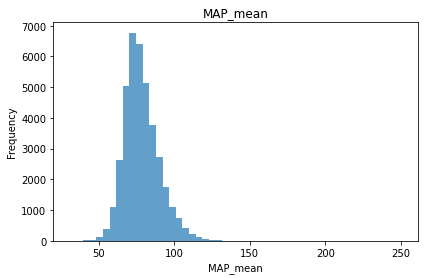

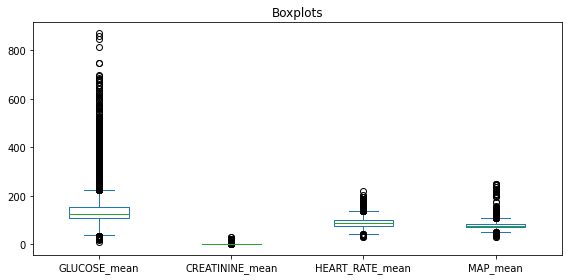

In [6]:
# Missingness overview (sparsity check: rows missing feature value)
miss = (1 - df[num_cols].notna().mean()).sort_values(ascending=False)
print("Top missing numeric:", miss.head(10))

# Histograms top 4
for f in [x for x in ['GLUCOSE_mean','CREATININE_mean','HEART_RATE_mean','MAP_mean'] if x in df.columns]:
    df[f].plot(kind='hist', bins=50, alpha=0.7, title=f); plt.xlabel(f); plt.tight_layout(); plt.show()

# Boxplots
to_plot = [x for x in ['GLUCOSE_mean','CREATININE_mean','HEART_RATE_mean','MAP_mean'] if x in df.columns]
if to_plot:
    df[to_plot].plot(kind='box', figsize=(8,4), title="Boxplots"); plt.tight_layout(); plt.show()

Feature availability

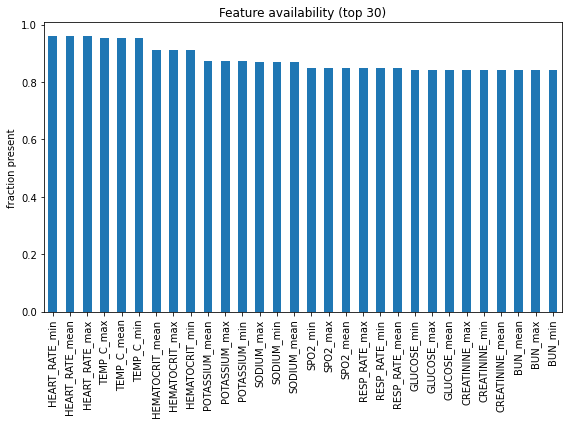

In [7]:
num_cols = [c for c in df.columns if c.endswith(("_mean","_min","_max"))]
avail = df[num_cols].notna().mean().sort_values(ascending=False).head(30)
plt.figure(figsize=(8,6)); avail.plot(kind="bar"); plt.ylabel("fraction present"); plt.title("Feature availability (top 30)"); plt.tight_layout()
# plt.savefig(os.path.join(base_dir, "FIGS", "01_availability_top30.png"), dpi=200)

Label balance

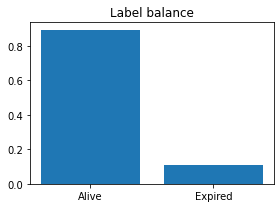

In [8]:
p = df['HOSPITAL_EXPIRE_FLAG'].mean()
plt.figure(figsize=(4,3))
plt.bar(["Alive","Expired"], [1-p, p]); plt.title("Label balance"); plt.tight_layout()
# plt.savefig(os.path.join(base_dir, "FIGS", "01_label_balance.png"), dpi=200)

Key lables

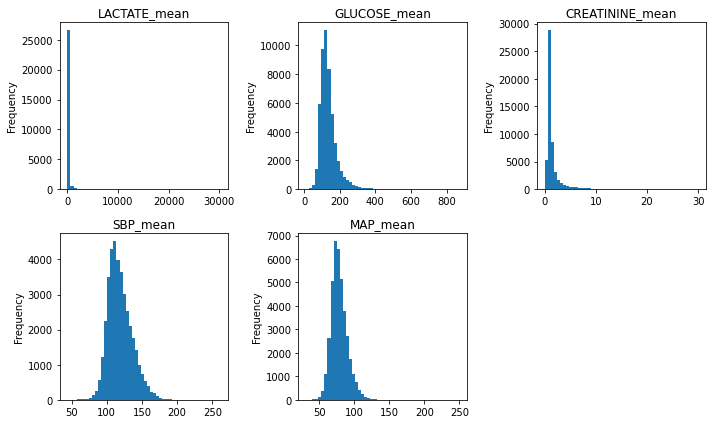

In [9]:
keys = ["LACTATE_mean","GLUCOSE_mean","CREATININE_mean","SBP_mean","MAP_mean"]
plt.figure(figsize=(10,6))
for i,k in enumerate([x for x in keys if x in df.columns], 1):
    plt.subplot(2,3,i); df[k].dropna().plot(kind="hist", bins=50); plt.title(k)
plt.tight_layout(); # plt.savefig(os.path.join(base_dir, "FIGS", "01_histograms.png"), dpi=200)

Correlation heatmap of numeric features

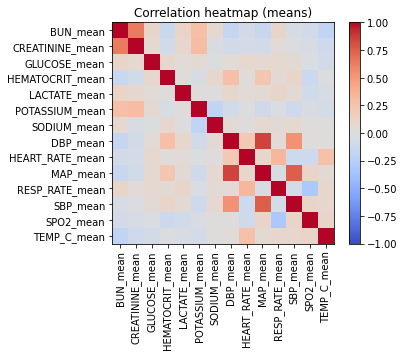

In [10]:
sub = df[[c for c in num_cols if c.endswith("_mean")]].dropna().sample(5000, random_state=SEED)
corr = sub.corr().values
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1); plt.colorbar(); plt.title("Correlation heatmap (means)")
plt.xticks(ticks=range(len(sub.columns)), labels=sub.columns, rotation=90)
plt.yticks(ticks=range(len(sub.columns)), labels=sub.columns)
plt.tight_layout()
# plt.xticks([]); plt.yticks([]); plt.tight_layout()
# plt.savefig(os.path.join(base_dir, "FIGS", "01_corr_means.png"), dpi=200)

In [10]:
df.to_csv(os.path.join(base_dir, "SNAP", "master_24h_snapshot.csv"), index=False)

Train-test split by SUBJECT_ID

In [11]:
subjects = df['SUBJECT_ID'].dropna().unique()
train_ids, test_ids = train_test_split(subjects, test_size=0.2, random_state=42)

train_df = df[df['SUBJECT_ID'].isin(train_ids)].copy()
test_df  = df[df['SUBJECT_ID'].isin(test_ids)].copy()

print("Train size:", train_df.shape, " Test size:", test_df.shape)
print("Train label ratio:", train_df[label_col].mean(), " Test label ratio:", test_df[label_col].mean())

Train size: (49293, 54)  Test size: (12239, 54)
Train label ratio: 0.10823037753839287  Test label ratio: 0.10409347168886347


Percentile capping on training set only (winsorization)
(cast outliers to the nearest values instead of dropping them)

In [12]:
# Compute caps from training only
low_q = 0.005
high_q = 0.995

train_caps = {
    c: (train_df[c].quantile(low_q), train_df[c].quantile(high_q))
    for c in num_cols
}

def apply_caps(frame, caps):
    out = frame.copy()
    for c, (lo, hi) in caps.items():
        if c in out.columns:
            out[c] = out[c].clip(lower=lo, upper=hi)
    return out

train_df = apply_caps(train_df, train_caps)
test_df  = apply_caps(test_df,  train_caps)  # train caps on test

Impute/fill in missing values (training statistics only)

In [13]:
# Numeric medians from training
num_medians = {c: float(train_df[c].median()) for c in num_cols}

# Categorical most frequent from training
cat_modes = {c: train_df[c].mode(dropna=True)[0] if train_df[c].notna().any() else "UNKNOWN" for c in cat_cols}

def impute(frame):
    out = frame.copy()
    for c in num_cols:
        if c in out.columns:
            out[c] = out[c].fillna(num_medians[c])
    for c in cat_cols:
        out[c] = out[c].astype('category').cat.add_categories(["UNKNOWN"]).fillna(cat_modes[c])
    return out

train_df = impute(train_df)
test_df  = impute(test_df)

Assembling modeling tables and saving

In [14]:
# Keep SUBJECT_ID
keep_cols = ['SUBJECT_ID'] + num_cols + cat_cols + [label_col]

train_out = train_df[keep_cols].copy()
test_out  = test_df[keep_cols].copy()

os.makedirs(os.path.join(base_dir, "CLEAN"), exist_ok=True)
train_csv = os.path.join(base_dir, "CLEAN", "train_clean.csv")
test_csv  = os.path.join(base_dir, "CLEAN", "test_clean.csv")
train_out.to_csv(train_csv, index=False)
test_out.to_csv(test_csv, index=False)

# Save metadata
meta = {
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "label_col": label_col,
    "winsor_low_q": low_q,
    "winsor_high_q": high_q,
    "num_medians": num_medians,
    "cat_modes": cat_modes,
    "dropped_cols": drop_cols,
    "source_file": in_csv
}
with open(os.path.join(base_dir, "CLEAN", "preprocess_metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

Quality checks after saving

In [15]:
t_train = pd.read_csv(train_csv)
t_test  = pd.read_csv(test_csv)
print(t_train.shape, t_test.shape)
print("Any NA in numeric train:", t_train[num_cols].isna().any().any())
print("Any NA in numeric test :", t_test[num_cols].isna().any().any())
print("Categorical levels:", {c: t_train[c].astype('category').cat.categories.tolist() for c in cat_cols})

(49293, 46) (12239, 46)
Any NA in numeric train: False
Any NA in numeric test : False
Categorical levels: {'GENDER': ['F', 'M'], 'ADMISSION_TYPE': ['ELECTIVE', 'EMERGENCY', 'NEWBORN', 'URGENT']}
